In [1]:
%pip install numpy matplotlib streamlit librosa soundfile scipy scikit-image scikit-learn

Note: you may need to restart the kernel to use updated packages.


STEP 1: Loading Images
Found 160 images in directory

Selected images:
  1. women-girl-gf81cdab46_640.jpg
  2. people-g4cbd1dbc4_640.jpg
  3. in-love-g33a19ee34_640.jpg

Loaded 3 images with shape (256, 256)


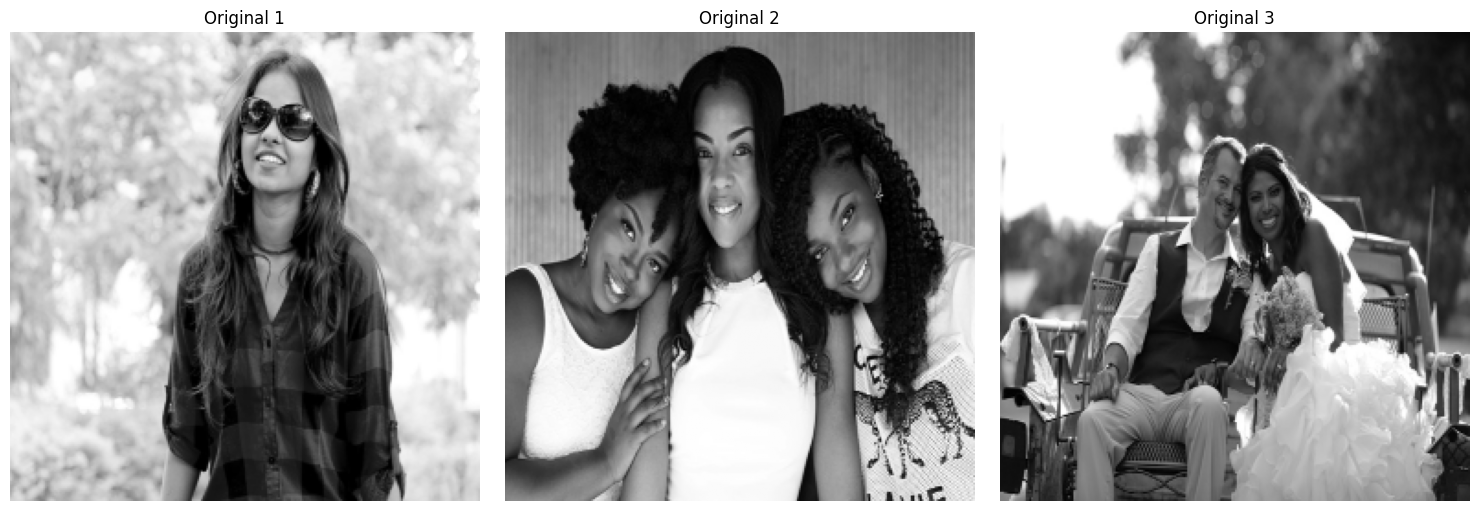


STEP 2: Creating Mixed Images
Source matrix S shape: (3, 65536)
Mixing matrix A shape: (3, 3)
Mixing matrix A:
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]]
Mixed matrix X shape: (3, 65536)


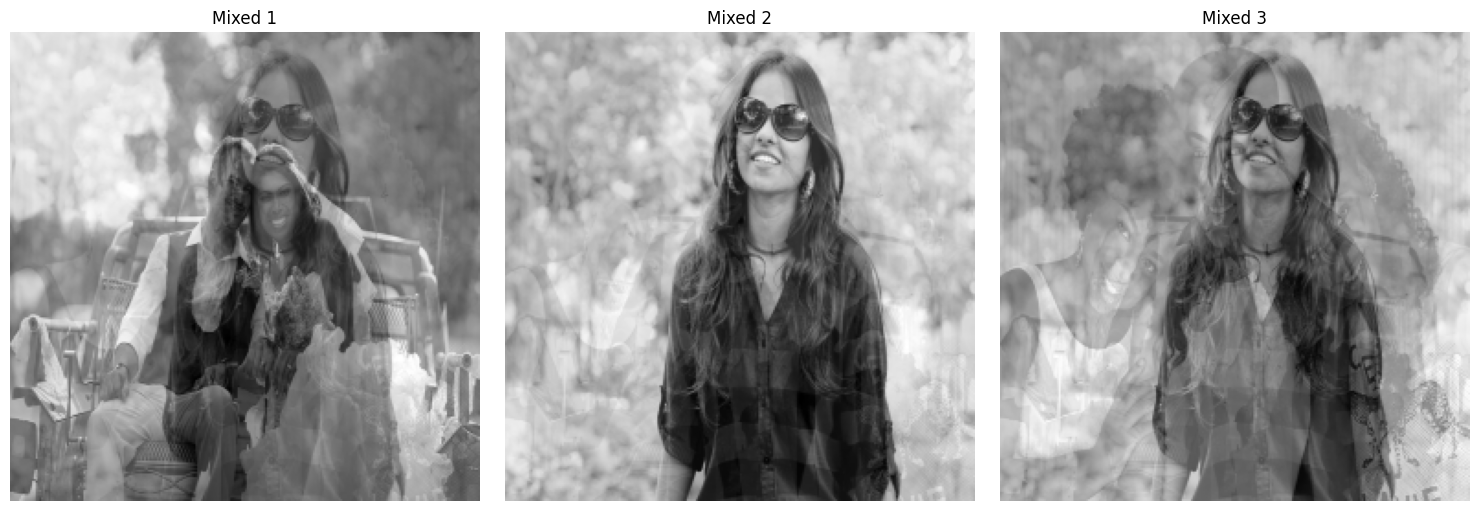


STEP 3: Applying FastICA
ICA converged in 9 iterations
ICA separated sources shape: (3, 65536)


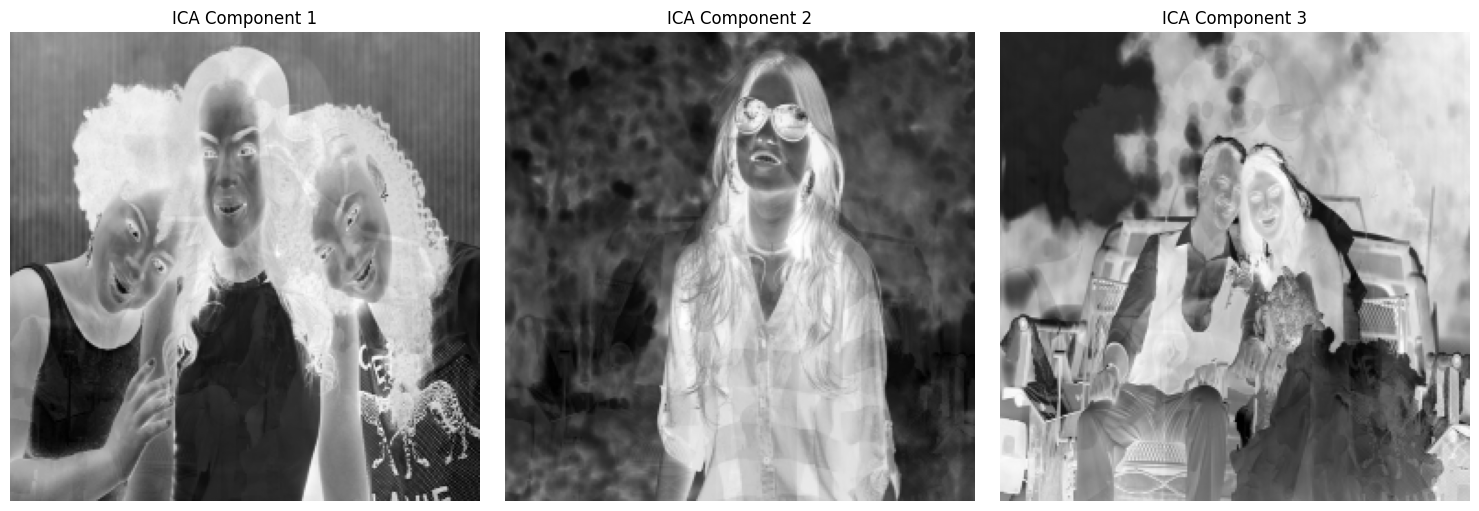


STEP 4: Applying PCA
PCA explained variance ratio: [0.82609032 0.13185231 0.04205737]
PCA separated sources shape: (3, 65536)


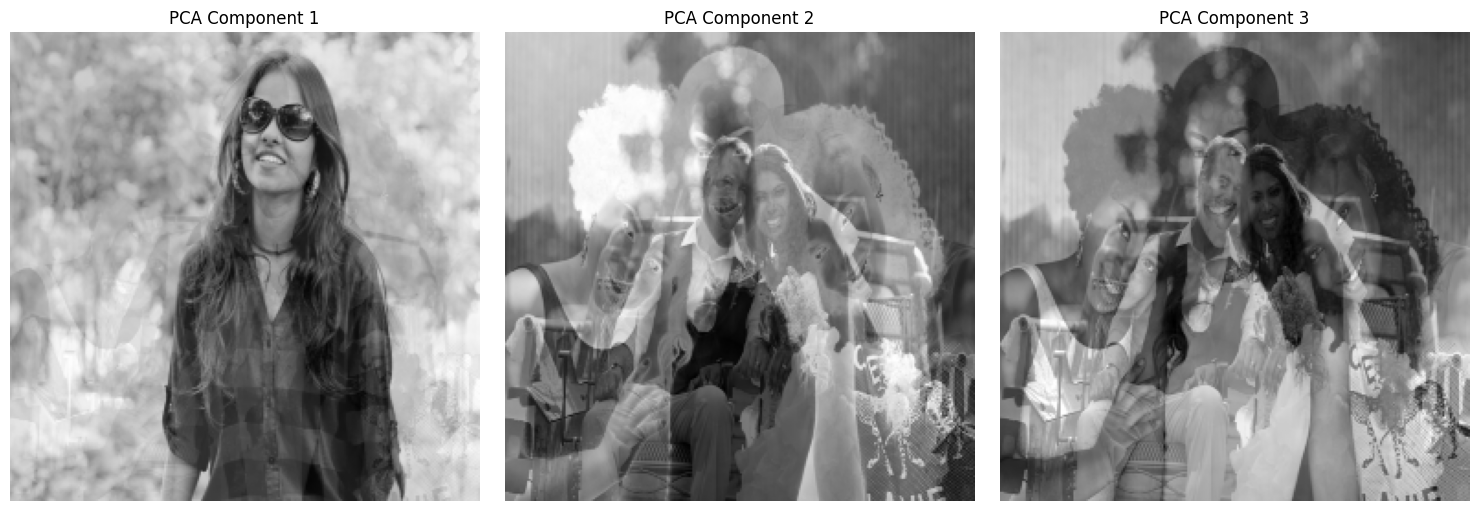


STEP 5: Comparison Visualization


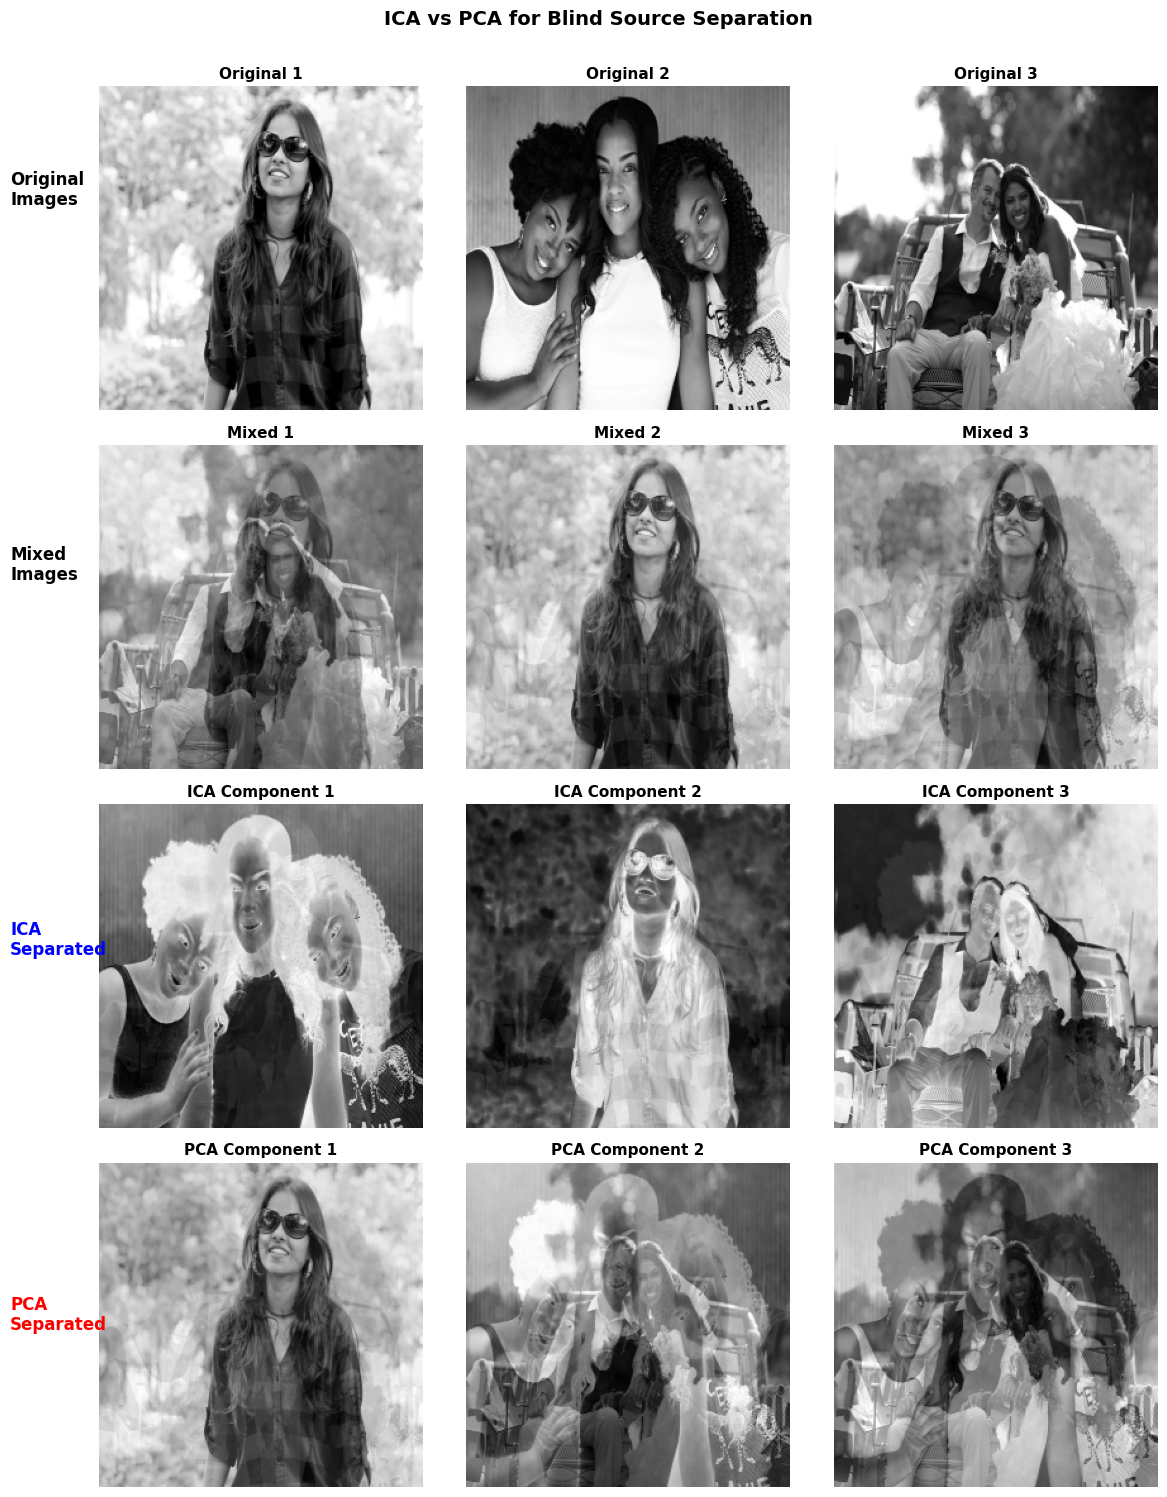


STEP 6: Saving Results

Saved all images to 'ica_image_outputs/'
  - 3 original images
  - 3 mixed images
  - 3 ICA components
  - 3 PCA components

ANALYSIS SUMMARY

Key Observations:
1. ICA (Independent Component Analysis):
   - Attempts to recover statistically independent sources
   - Better for separating mixed signals with non-Gaussian distributions
   - Should recover images similar to originals (order may vary)

2. PCA (Principal Component Analysis):
   - Finds orthogonal directions of maximum variance
   - Optimizes for decorrelation, not independence
   - Often produces 'averaged' or 'blurred' components

3. Comparison:
   - ICA generally performs better for blind source separation
   - PCA is useful for dimensionality reduction and noise removal
   - ICA components should look more like original images

Analysis Complete!


In [ ]:
# Blind Source Separation of Mixed Images using ICA and PCA
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
from skimage import io, color, transform
import warnings
warnings.filterwarnings('ignore')

# %%
# ----- Utility functions -----

def load_and_preprocess_image(path, size=(256, 256)):
    """Load image, convert to grayscale, resize, and normalize"""
    img = io.imread(path)
    
    # Convert to grayscale if needed
    if img.ndim == 3:
        img = color.rgb2gray(img)
    
    # Resize to standard size
    img = transform.resize(img, size, anti_aliasing=True)
    
    # Normalize to [0, 1]
    img = (img - img.min()) / (img.max() - img.min() + 1e-10)
    
    return img


def select_diverse_images(image_dir, n_images=3):
    """
    Select n diverse images from directory based on variance
    This helps ensure we get visually different images for better separation
    """
    # Get all image files
    patterns = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    image_paths = []
    for pattern in patterns:
        image_paths.extend(glob.glob(os.path.join(image_dir, pattern)))
        image_paths.extend(glob.glob(os.path.join(image_dir, pattern.upper())))
    
    if len(image_paths) == 0:
        raise ValueError(f"No images found in {image_dir}")
    
    print(f"Found {len(image_paths)} images in directory")
    
    # If we have fewer images than requested, use all
    if len(image_paths) <= n_images:
        return image_paths[:n_images]
    
    # Load a sample of images and compute their variance
    # Select images with highest variance (most diverse content)
    sample_size = min(20, len(image_paths))
    sample_paths = np.random.choice(image_paths, sample_size, replace=False)
    
    variances = []
    for path in sample_paths:
        try:
            img = load_and_preprocess_image(path, size=(128, 128))
            variances.append((path, np.var(img)))
        except:
            continue
    
    # Sort by variance and select top n_images
    variances.sort(key=lambda x: x[1], reverse=True)
    selected_paths = [v[0] for v in variances[:n_images]]
    
    return selected_paths


def normalize_component(x):
    """Normalize to [0, 1] range"""
    x = x - np.min(x)
    x = x / (np.max(x) + 1e-10)
    return x


def plot_images(images, titles=None, cmap='gray', figsize=(15, 5)):
    """Plot multiple images in a row"""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=cmap, vmin=0, vmax=1)
        if titles:
            ax.set_title(titles[i], fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_comparison_grid(originals, mixed, ica_components, pca_components):
    """Create comprehensive comparison grid"""
    fig, axes = plt.subplots(4, 3, figsize=(12, 15))
    
    # Row 1: Original images
    for i in range(3):
        axes[0, i].imshow(originals[i], cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(f'Original {i+1}', fontsize=11, fontweight='bold')
        axes[0, i].axis('off')
    
    # Row 2: Mixed images
    for i in range(3):
        axes[1, i].imshow(mixed[i], cmap='gray', vmin=0, vmax=1)
        axes[1, i].set_title(f'Mixed {i+1}', fontsize=11, fontweight='bold')
        axes[1, i].axis('off')
    
    # Row 3: ICA separated
    for i in range(3):
        axes[2, i].imshow(ica_components[i], cmap='gray', vmin=0, vmax=1)
        axes[2, i].set_title(f'ICA Component {i+1}', fontsize=11, fontweight='bold')
        axes[2, i].axis('off')
    
    # Row 4: PCA separated
    for i in range(3):
        axes[3, i].imshow(pca_components[i], cmap='gray', vmin=0, vmax=1)
        axes[3, i].set_title(f'PCA Component {i+1}', fontsize=11, fontweight='bold')
        axes[3, i].axis('off')
    
    # Add row labels
    fig.text(0.01, 0.875, 'Original\nImages', fontsize=12, fontweight='bold', va='center')
    fig.text(0.01, 0.625, 'Mixed\nImages', fontsize=12, fontweight='bold', va='center')
    fig.text(0.01, 0.375, 'ICA\nSeparated', fontsize=12, fontweight='bold', va='center', color='blue')
    fig.text(0.01, 0.125, 'PCA\nSeparated', fontsize=12, fontweight='bold', va='center', color='red')
    
    plt.suptitle('ICA vs PCA for Blind Source Separation', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0.05, 0, 1, 0.99])
    plt.show()

# %%
# ----- Parameters -----
IMAGE_DIR = 'images_input'
OUTPUT_DIR = 'ica_image_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

N_COMPONENTS = 3
IMG_SIZE = (256, 256)

# %%
# ----- Load and select images -----
print("=" * 60)
print("STEP 1: Loading Images")
print("=" * 60)

selected_paths = select_diverse_images(IMAGE_DIR, n_images=N_COMPONENTS)

print(f"\nSelected images:")
for i, path in enumerate(selected_paths, 1):
    print(f"  {i}. {os.path.basename(path)}")

# Load and preprocess images
originals = []
for path in selected_paths:
    img = load_and_preprocess_image(path, size=IMG_SIZE)
    originals.append(img)

print(f"\nLoaded {len(originals)} images with shape {IMG_SIZE}")
plot_images(originals, titles=[f'Original {i+1}' for i in range(N_COMPONENTS)])

# %%
# ----- Create mixtures -----
print("\n" + "=" * 60)
print("STEP 2: Creating Mixed Images")
print("=" * 60)

# Flatten images into vectors and stack them
# Each row is one source image flattened
S = np.array([img.flatten() for img in originals])  # shape: (n_components, n_pixels)
print(f"Source matrix S shape: {S.shape}")

# Create random mixing matrix
np.random.seed(42)
A = np.random.randn(N_COMPONENTS, N_COMPONENTS)
print(f"Mixing matrix A shape: {A.shape}")
print(f"Mixing matrix A:\n{A}")

# Mix the signals: X = A @ S
X = np.dot(A, S)  # shape: (n_components, n_pixels)
print(f"Mixed matrix X shape: {X.shape}")

# Reshape back to images
mixed_images = [normalize_component(x.reshape(IMG_SIZE)) for x in X]
plot_images(mixed_images, titles=[f'Mixed {i+1}' for i in range(N_COMPONENTS)])

# %%
# ----- Apply FastICA -----
print("\n" + "=" * 60)
print("STEP 3: Applying FastICA")
print("=" * 60)

# Transpose for sklearn format: (n_samples, n_features)
X_T = X.T  # shape: (n_pixels, n_components)

ica = FastICA(n_components=N_COMPONENTS, random_state=0, max_iter=2000, tol=0.001)
S_ica_T = ica.fit_transform(X_T)  # shape: (n_pixels, n_components)
S_ica = S_ica_T.T  # shape: (n_components, n_pixels)

print(f"ICA converged in {ica.n_iter_} iterations")
print(f"ICA separated sources shape: {S_ica.shape}")

# Reshape to images
ica_images = [normalize_component(s.reshape(IMG_SIZE)) for s in S_ica]
plot_images(ica_images, titles=[f'ICA Component {i+1}' for i in range(N_COMPONENTS)])

# %%
# ----- Apply PCA -----
print("\n" + "=" * 60)
print("STEP 4: Applying PCA")
print("=" * 60)

pca = PCA(n_components=N_COMPONENTS)
S_pca_T = pca.fit_transform(X_T)  # shape: (n_pixels, n_components)
S_pca = S_pca_T.T  # shape: (n_components, n_pixels)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"PCA separated sources shape: {S_pca.shape}")

# Reshape to images
pca_images = [normalize_component(s.reshape(IMG_SIZE)) for s in S_pca]
plot_images(pca_images, titles=[f'PCA Component {i+1}' for i in range(N_COMPONENTS)])

# %%
# ----- Comprehensive comparison -----
print("\n" + "=" * 60)
print("STEP 5: Comparison Visualization")
print("=" * 60)

plot_comparison_grid(originals, mixed_images, ica_images, pca_images)

# %%
# ----- Save outputs -----
print("\n" + "=" * 60)
print("STEP 6: Saving Results")
print("=" * 60)

# Save original images
for i, img in enumerate(originals):
    io.imsave(os.path.join(OUTPUT_DIR, f'original_{i+1}.png'), 
              (img * 255).astype(np.uint8), check_contrast=False)

# Save mixed images
for i, img in enumerate(mixed_images):
    io.imsave(os.path.join(OUTPUT_DIR, f'mixed_{i+1}.png'), 
              (img * 255).astype(np.uint8), check_contrast=False)

# Save ICA components
for i, img in enumerate(ica_images):
    io.imsave(os.path.join(OUTPUT_DIR, f'ica_component_{i+1}.png'), 
              (img * 255).astype(np.uint8), check_contrast=False)

# Save PCA components
for i, img in enumerate(pca_images):
    io.imsave(os.path.join(OUTPUT_DIR, f'pca_component_{i+1}.png'), 
              (img * 255).astype(np.uint8), check_contrast=False)

print(f"\nSaved all images to '{OUTPUT_DIR}/'")
print(f"  - {N_COMPONENTS} original images")
print(f"  - {N_COMPONENTS} mixed images")
print(f"  - {N_COMPONENTS} ICA components")
print(f"  - {N_COMPONENTS} PCA components")

# %%
# ----- Analysis Summary -----
print("\n" + "=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)

print("\nKey Observations:")
print("1. ICA (Independent Component Analysis):")
print("   - Attempts to recover statistically independent sources")
print("   - Better for separating mixed signals with non-Gaussian distributions")
print("   - Should recover images similar to originals (order may vary)")

print("\n2. PCA (Principal Component Analysis):")
print("   - Finds orthogonal directions of maximum variance")
print("   - Optimizes for decorrelation, not independence")
print("   - Often produces 'averaged' or 'blurred' components")

print("\n3. Comparison:")
print("   - ICA generally performs better for blind source separation")
print("   - PCA is useful for dimensionality reduction and noise removal")
print("   - ICA components should look more like original images")

print("\n" + "=" * 60)
print("Analysis Complete!")
print("=" * 60)